<div style='background-image: url("https://tinyurl.com/587zdbkm/title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite Volume Method - 1D Elastic Wave Equation. Heterogeneous case</div>
        </div>
    </div>
</div>

## Exercise
* Change frequency content, CFL Limit, source location, discuss differences in FD and FV solutions


## Basic Equations

The source free elastic wave equation can be written in terms of a coupled first-order system 

\begin{align}
\partial_t \sigma - \mu \partial_x v & = 0 \\ 
\partial_t v - \frac{1}{\rho} \partial_x \sigma & = 0
\end{align}

with $\rho$ the density and $\mu$ the shear modulus. This equation in matrix-vector notation follows

\begin{equation}
\partial_t \mathbf{Q} + \mathbf{A} \partial_x \mathbf{Q} = 0
\end{equation}

where $\mathbf{Q} = (\sigma, v)$ is the vector of unknowns and the matrix $\mathbf{A}$ contains the parameters $\rho$ and $\mu$. The above matrix equation is analogous to the advection equation $\partial_t q + a \partial_x q = 0$. Although it is a coupled system, diagonalization of $\mathbf{A} = \mathbf{R}^{-1}\mathbf{\Lambda}\mathbf{R}$ allows us to implement all elements developed for the solution of the advection equation in terms of fluxes. It turns out that the decoupled version is

\begin{equation}
\partial_t \mathbf{W} + \mathbf{\Lambda} \partial_x \mathbf{W} = 0
\end{equation}

with $\mathbf{W} = \mathbf{R}^{-1}\mathbf{Q}$, where the eigenvector matrix $\mathbf{R}$ and the diagonal matrix of eigenvalues $\mathbf{\Lambda}$ are given for the heterogeneous case 

\begin{equation}
\mathbf{\Lambda}_i=
     \begin{pmatrix}
       -c_i & 0 \\
        0 & c_i 
     \end{pmatrix}
\qquad\text{,}\qquad
\mathbf{A}_i=
     \begin{pmatrix}
        0 & -\mu_i \\
        -1/\rho_i & 0 
     \end{pmatrix}
\qquad\text{,}\qquad
\mathbf{R} =  
     \begin{pmatrix}
       Z_i & -Z_i \\
       1 &  1 
     \end{pmatrix}
\qquad\text{and}\qquad
\mathbf{R}^{-1} = \frac{1}{2Z_i}
     \begin{pmatrix}
       1 & Z_i \\
      -1 & Z_i 
     \end{pmatrix}
\end{equation}

Here $Z_i = \rho_i c_i$ represents the seismic impedance. In comparison with the homogeneous case, here we allow coefficients of matrix $\mathbf{A}$ to vary for each element

This notebook implements the Lax-Wendroff scheme for solving the free source version of the elastic wave equation in a heterogeneous media. This solution is compared with the one obtained using the finite difference scheme. To keep the problem simple we use as spatial initial condition a Gauss function with half-width $\sigma$

\begin{equation}
Q(x,t=0)  = e^{-1/\sigma^2 (x - x_{o})^2}
\end{equation}


In [1]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib
%matplotlib ipympl

import matplotlib.pyplot as plt
import matplotlib.animation as animation


### 1. Initialization of setup

In [7]:
# Initialization of setup
# --------------------------------------------------------------------------
nx    = 800         # number of grid points 
c0    = 2500        # acoustic velocity in m/s
rho    = 2500       # density in kg/m^3
Z0    = rho*c0      # impedance
mu    = rho*c0**2   # shear modulus
rho0  = rho         # density
mu0   = mu          # shear modulus

xmax  = 10000       # in m 
eps   = 0.5         # CFL
tmax  = 0.7         # simulation time in s
isnap = 10          # plotting rate
sig   = 200         # argument in the inital condition
x0    = 2500        # position of the initial condition

### 2. Finite Differences setup

In [8]:
# Finite Differences setup 
# --------------------------------------------------------------------------  
dx    = xmax/(nx-1)                  # calculate space increment
xfd   = np.arange(0, nx)*dx          # initialize space 
mufd  = np.zeros(xfd.size) + mu0     # initialize shear modulus 
rhofd = np.zeros(xfd.size) + rho0    # initialize density 

# Introduce inhomogeneity
mufd[int((nx-1)/2) + 1:nx] = mufd[int((nx-1)/2) + 1:nx]*4

# initialize fields
s  = np.zeros(xfd.size)
v  = np.zeros(xfd.size)
dv = np.zeros(xfd.size)
ds = np.zeros(xfd.size)
s  = np.exp(-1./sig**2 * (xfd-x0)**2)   # Initial condition

### 3. Finite Volumes setup

In [9]:
# Finite Volumes setup 
# --------------------------------------------------------------------------  
A = np.zeros((2,2,nx))
Z = np.zeros((1,nx))
c = np.zeros((1,nx))

# Initialize velocity
c = c + c0
c[int(nx/2):nx] = c[int(nx/2):nx]*2
Z = rho*c

# Initialize A for each cell
for i in range(1,nx):    
    A0 = np.array([[0, -mu], [-1/rho, 0]])
    if i > nx/2:
        A0= np.array([[0, -4*mu], [-1/rho, 0]])
    A[:,:,i] = A0 

# Initialize Space
x, dx = np.linspace(0,xmax,nx,retstep=True)

# use wave based CFL criterion
dt = eps*dx/np.max(c) # calculate tim step from stability criterion

# Simulation time
nt = int(np.floor(tmax/dt))

# Initialize wave fields
Q = np.zeros((2,nx))
Qnew = np.zeros((2,nx))

### 4. Initial condition

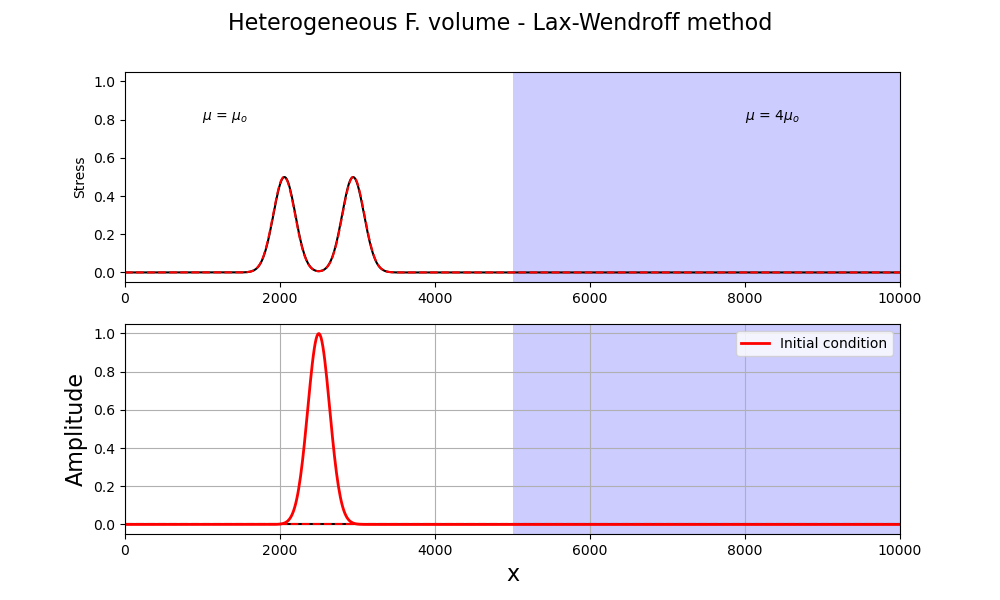

In [10]:
# Initial condition
#----------------------------------------------------------------
sx = np.exp(-1./sig**2 * (x-x0)**2)
Q[0,:] = sx

# ---------------------------------------------------------------
# Plot initial condition
# ---------------------------------------------------------------
plt.plot(x, sx, color='r', lw=2, label='Initial condition')
plt.ylabel('Amplitude', size=16)
plt.xlabel('x', size=16)
plt.legend()
plt.grid(True)
plt.show()

### 4. Solution for the inhomogeneous problem

#### Upwind finite volume scheme
We decompose the solution into right propagating $\mathbf{\Lambda}_i^{+}$ and left propagating eigenvalues $\mathbf{\Lambda}_i^{-}$ where

\begin{equation}
\mathbf{\Lambda}_i^{+}=
     \begin{pmatrix}
       -c_i & 0 \\
        0 & 0 
     \end{pmatrix}
\qquad\text{,}\qquad
\mathbf{\Lambda}_i^{-}=
     \begin{pmatrix}
        0 & 0 \\
        0 & c_i 
     \end{pmatrix}
\qquad\text{and}\qquad
\mathbf{A}_i^{\pm} = \mathbf{R}^{-1}\mathbf{\Lambda}_i^{\pm}\mathbf{R}
\end{equation}

This strategy allows us to formulate an upwind finite volume scheme for any hyperbolic system as 

\begin{equation}
\mathbf{Q}_{i}^{n+1}  = \mathbf{Q}_{i}^{n} - \frac{dt}{dx}(\mathbf{A}_i^{+}\Delta\mathbf{Q}_{l} - \mathbf{A}_i^{-}\Delta\mathbf{Q}_{r})
\end{equation}

with corresponding flux term given by

\begin{equation}
\mathbf{F}_{l} =  \mathbf{A}_i^{+}\Delta\mathbf{Q}_{l}
\qquad\text{,}\qquad
\mathbf{F}_{r}  =  \mathbf{A}_i^{-}\Delta\mathbf{Q}_{r}
\end{equation}

#### Lax-Wendroff finite volume scheme

The upwind solution presents a strong diffusive behavior. In this sense, the Lax-Wendroff perform better, with the advantage that it is not needed to decompose the eigenvalues into right and left propagations. Here the matrix $\mathbf{A}_i$ can be used in its original form. The Lax-Wendroff follows

\begin{equation}
\mathbf{Q}_{i}^{n+1}  = \mathbf{Q}_{i}^{n} - \frac{dt}{2dx}\mathbf{A}_i(\Delta\mathbf{Q}_{l} + \Delta\mathbf{Q}_{r}) + \frac{1}{2}\Big(\frac{dt}{dx}\Big)^2\mathbf{A}_i^2(\Delta\mathbf{Q}_{l} - \Delta\mathbf{Q}_{r})
\end{equation} 

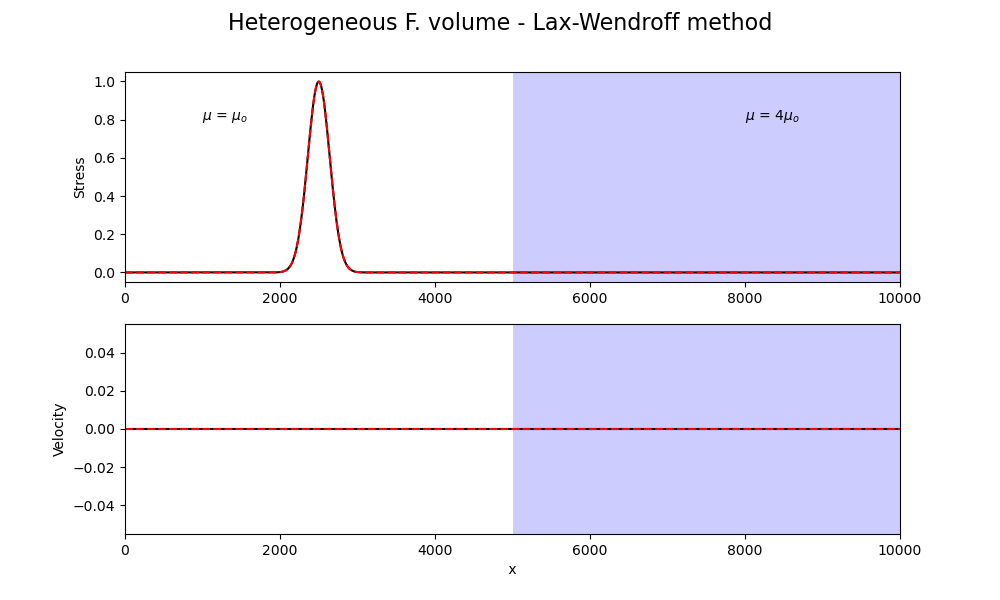

In [11]:
# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
ax1.axvspan(((nx-1)/2+1)*dx, nx*dx, alpha=0.2, facecolor='b')
ax2.axvspan(((nx-1)/2+1)*dx, nx*dx, alpha=0.2, facecolor='b')
ax1.set_xlim([0, xmax])
ax2.set_xlim([0, xmax])
ax1.set_ylabel('Stress')
ax2.set_ylabel('Velocity')
ax2.set_xlabel(' x ')

line1 = ax1.plot(x, Q[0,:], 'k', x, s, 'r--')
line2 = ax2.plot(x, Q[1,:], 'k', x, v, 'r--')

plt.suptitle('Heterogeneous F. volume - Lax-Wendroff method', size=16)
ax1.text(0.1*xmax, 0.8*max(sx), '$\mu$ = $\mu_{o}$')
ax1.text(0.8*xmax, 0.8*max(sx), '$\mu$ = $4\mu_{o}$')

plt.ion()    # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------  
for j in range(nt):
    # Finite Volume Extrapolation scheme-------------------------
    for i in range(1,nx-1): 
        # Lax-Wendroff method
        dQl = Q[:,i] - Q[:,i-1]
        dQr = Q[:,i+1] - Q[:,i]      
        Qnew[:,i] = Q[:,i] - dt/(2*dx)*A[:,:,i] @ (dQl + dQr)\
                + 1/2*(dt/dx)**2 *A[:,:,i] @ A[:,:,i] @ (dQr - dQl)
    # Absorbing boundary conditions
    Qnew[:,0] = Qnew[:,1]
    Qnew[:,nx-1] = Qnew[:,nx-2]
    Q, Qnew = Qnew, Q

    # Finite Difference Extrapolation scheme---------------------
    # Stress derivative
    for i in range(1, nx-1):
        ds[i] = (s[i+1] - s[i])/dx 
    # Velocity extrapolation
    v = v + dt*ds/rhofd
    # Velocity derivative
    for i in range(1, nx-1):
        dv[i] = (v[i] - v[i-1])/dx 
    # Stress extrapolation
    s = s + dt*mufd*dv 

    # --------------------------------------   
    # Animation plot. Display solutions
    if not j % isnap: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l 

        line1 = ax1.plot(x, Q[0,:], 'k', x, s, 'r--')
        line2 = ax2.plot(x, Q[1,:], 'k', x, v, 'r--')
        plt.legend(iter(line2), ('F. Volume', 'f. Diff'))
        plt.gcf().canvas.draw()
